In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Lasso, BayesianRidge
from scipy.stats import boxcox
from sklearn.preprocessing import Normalizer
def corr_df(x, corr_val):
   
    # Creates Correlation Matrix and Instantiates
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterates through Correlation Matrix Table to find correlated columns
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = item.values
            if val >= corr_val:
                # Prints the correlated feature set and the corr val
                print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(i)

    drops = sorted(set(drop_cols))[::-1]
    return drops

In [2]:
homes = pd.read_csv('home_train.csv')
X = homes.copy()
y = X.pop('SalePrice')

Заполнение значений NaN и удаление некоторых выбросов

In [3]:
#Удалили выбросы

X = X.drop(homes[homes.LotFrontage>300].index)
y = y.drop(homes[homes.LotFrontage>300].index)
X = X.drop(homes[homes.MasVnrArea>1500].index)
y = y.drop(homes[homes.MasVnrArea>1500].index)

#Заполнение NaN средним
X.LotFrontage=X.LotFrontage.fillna(X.LotFrontage.median())

#Заполнение NaN на основе информации, данной в data_description

X.Alley=X.Alley.fillna('None')
X.MasVnrArea=X.MasVnrArea.fillna(X.MasVnrArea.median())
X.BsmtQual=X.BsmtQual.fillna('NoBsmt')
X.BsmtCond =X.BsmtCond.fillna('NoBsmt')
X.BsmtExposure =X.BsmtExposure.fillna('NoBsmt')
X.BsmtFinType1=X.BsmtFinType1.fillna('NoBsmt')
X.BsmtFinType2=X.BsmtFinType2.fillna('NoBsmt')
X.Electrical=X.Electrical.fillna(X.Electrical.mode())
X.FireplaceQu=X.FireplaceQu.fillna('NoFirepl')
X.GarageType =X.GarageType.fillna('NoGar')
X.GarageYrBlt=X.GarageYrBlt.fillna('NoGar')
X.GarageFinish=X.GarageFinish.fillna('NoGar')
X.GarageQual=X.GarageQual.fillna('NoGar')
X.GarageCond=X.GarageCond.fillna('NoGar')
X.PoolQC =X.PoolQC.fillna('NoPool')
X.Fence=X.Fence.fillna('NoFence')
X.MiscFeature=X.MiscFeature.fillna('NoMiscFeat')

Построим график корреляции числовых признаков.

<AxesSubplot:>

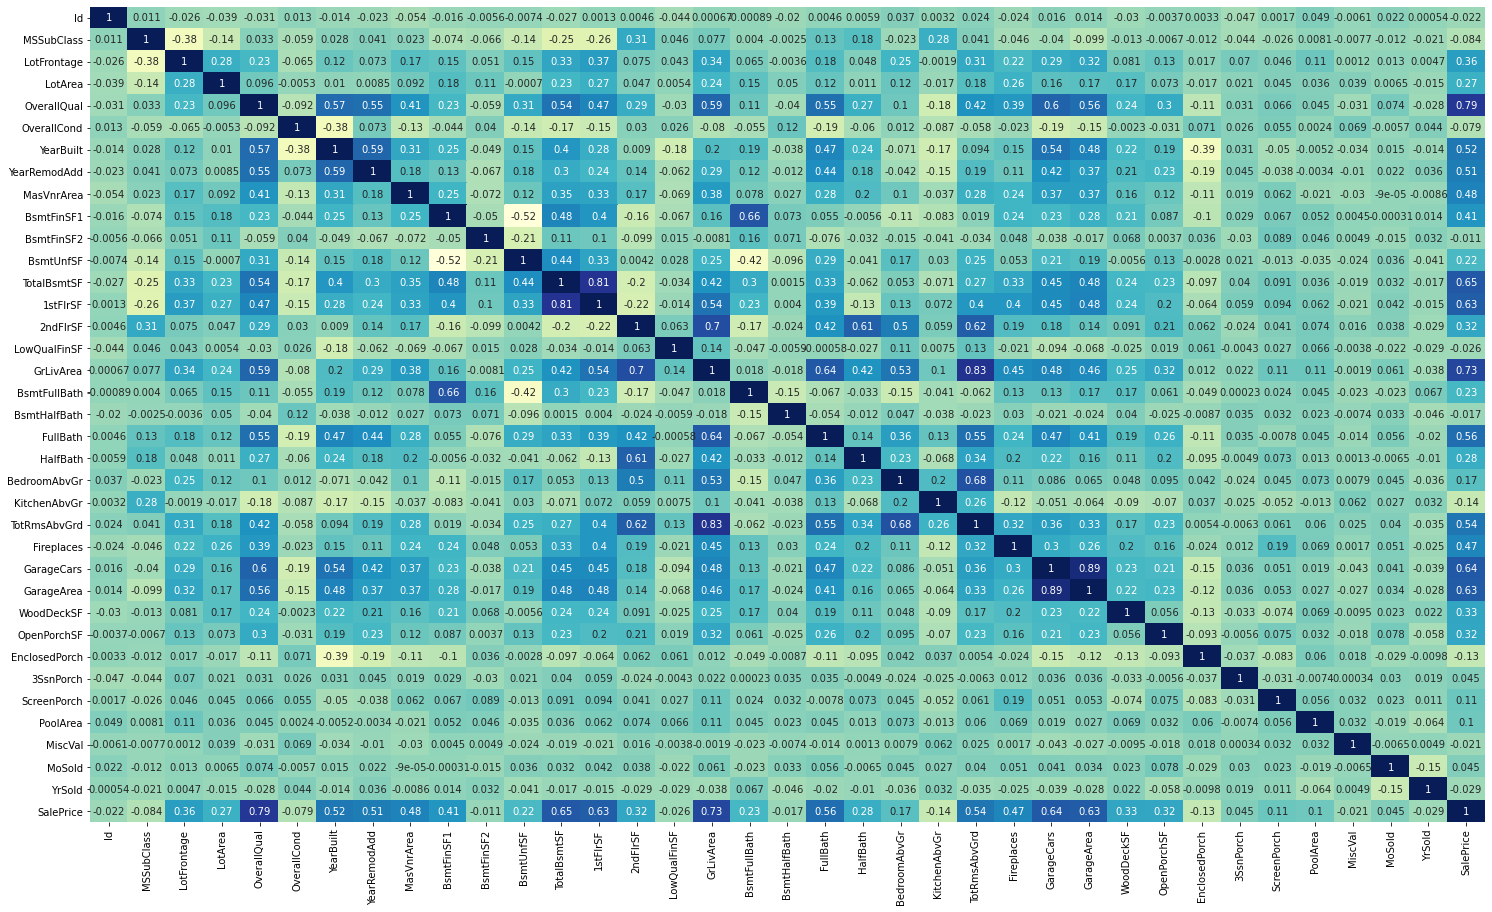

In [58]:
import matplotlib.pyplot as plt
Corr = pd.concat([X,y],axis=1, join='inner')#не используем homes, потому чо удалили некоторые строки и выполнили fillna, 
#хочется картину после этого
fig, ax = plt.subplots(figsize=(25,15)) 
sns.heatmap(Corr.corr(), annot=True, cmap='YlGnBu', linecolor='k', cbar=False)

Отбираем наименее коррелирующие с SalePrice признаки и удаляем их.

In [4]:
columns = ['Id','MSSubClass','BsmtFinSF2','LowQualFinSF','BsmtHalfBath','3SsnPorch','MiscVal','MoSold','YrSold']
X = X.drop(columns,axis=1)

In [5]:
#Выполним горячее кодирование
for column in X.select_dtypes("object"):
    X[column],_ = X[column].factorize()

Посмотрим какой получается результат на Kaggle для этого проделаем описанные выше действия с тестовым датасетом

In [7]:
test = pd.read_csv('test.csv')
X_test = test.copy()

In [8]:
X_test = X_test.drop(columns,axis=1)

In [9]:
X_test.LotFrontage=X_test.LotFrontage.fillna(X_test.LotFrontage.median())
X_test.Alley=X_test.Alley.fillna('None')
X_test.MasVnrArea=X_test.MasVnrArea.fillna(X_test.MasVnrArea.median())
X_test.BsmtQual=X_test.BsmtQual.fillna('NoBsmt')
X_test.BsmtCond =X_test.BsmtCond.fillna('NoBsmt')
X_test.BsmtExposure =X_test.BsmtExposure.fillna('NoBsmt')
X_test.BsmtFinType1=X_test.BsmtFinType1.fillna('NoBsmt')
X_test.BsmtFinType2=X_test.BsmtFinType2.fillna('NoBsmt')
X_test.BsmtFinSF1=X_test.BsmtFinSF1.fillna(X_test.BsmtFinSF1.median())
X_test.BsmtUnfSF=X_test.BsmtUnfSF.fillna(X_test.BsmtUnfSF.median() )
X_test.TotalBsmtSF=X_test.TotalBsmtSF.fillna(X_test.TotalBsmtSF.median())
X_test.BsmtFullBath=X_test.BsmtFullBath.fillna(X_test.BsmtFullBath.median())
X_test.Electrical=X_test.Electrical.fillna(X_test.Electrical.mode())
X_test.FireplaceQu=X_test.FireplaceQu.fillna('NoFirepl')
X_test.GarageType =X_test.GarageType.fillna('NoGar')
X_test.GarageYrBlt=X_test.GarageYrBlt.fillna('NoGar')
X_test.GarageFinish=X_test.GarageFinish.fillna('NoGar')
X_test.GarageQual=X_test.GarageQual.fillna('NoGar')
X_test.GarageCond=X_test.GarageCond.fillna('NoGar')
X_test.GarageCars=X_test.GarageCars.fillna('NoGar')
X_test.GarageArea=X_test.GarageArea.fillna('NoGar')
X_test.PoolQC =X_test.PoolQC.fillna('NoPool')
X_test.Fence=X_test.Fence.fillna('NoFence')
X_test.MiscFeature=X_test.MiscFeature.fillna('NoMiscFeat')
X_test.SaleType=X_test.SaleType.fillna(X_test.SaleType.mode())

In [10]:
#Выполним горячее кодирование
for column in X_test.select_dtypes("object"):
    X_test[column],_ = X_test[column].factorize()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, np.log(y),
                                                    test_size=0.3, random_state=42)
LR = LinearRegression()
params={'copy_X':[True, False],'fit_intercept':[True, False],'normalize':(True, False)}
grid = GridSearchCV(LR, params)
grid.fit(x_train,y_train)
grid.best_params_
grid.fit(x_train,y_train)
print(grid.score(x_train,y_train))
print(grid.score(x_test,y_test))

In [11]:
Predict = grid.predict(X_test)

NameError: name 'grid' is not defined

In [45]:
Predict_S = pd.DataFrame(np.exp(Predict),index=test.Id,columns=['SalePrice'])
Predict_S.to_csv('HousePrice6')# - получилось 24000

Вычислим mutual_information по отношению к целевой переменной для каждого из признаков и удалим признаки 
с наименьшим коэффициентом mi_score.

In [114]:
# Посмотрим на Mi score
mi_score = mutual_info_regression(X,y)
mi_score = pd.Series(data=mi_score, index=X.columns)
mi_score.sort_values(ascending=False).tail(30)

BsmtExposure     0.073823
GarageCond       0.069491
BedroomAbvGr     0.068912
CentralAir       0.067037
Electrical       0.049843
BsmtCond         0.047710
PavedDrive       0.044385
Fence            0.036867
BldgType         0.035166
BsmtFinType2     0.030515
Alley            0.029295
LandContour      0.025654
EnclosedPorch    0.025534
Condition1       0.021325
KitchenAbvGr     0.019212
BsmtFullBath     0.017983
ExterCond        0.015310
RoofStyle        0.015202
LotConfig        0.011950
Utilities        0.010803
Heating          0.007793
RoofMatl         0.007648
Condition2       0.005919
ScreenPorch      0.005838
PoolArea         0.003669
MiscFeature      0.000641
LandSlope        0.000405
PoolQC           0.000000
Functional       0.000000
Street           0.000000
dtype: float64

In [12]:
columns1 = ['MiscFeature','Condition2','Utilities','RoofMatl','LandSlope','RoofStyle','Heating','EnclosedPorch','Alley',
            'BsmtFinType2','BsmtCond','BedroomAbvGr','GarageCond','BsmtExposure']
X = X.drop(columns1,axis=1)

Посмотрим получилось ли увеличить точность модели

In [239]:
x_train, x_test, y_train, y_test = train_test_split(X, np.log(y),
                                                    test_size=0.3, random_state=42)
LR = LinearRegression()
params={'copy_X':[True, False],'fit_intercept':[True, False],'normalize':(True, False)}
grid = GridSearchCV(LR, params)
grid.fit(x_train,y_train)
grid.best_params_
grid.fit(x_train,y_train)
print(grid.score(x_train,y_train))
print(grid.score(x_test,y_test))

0.8983464169184269
0.9052172632413565


Создадим новые признаки на основе имеющихся.
Вычислим три новых признака обозначающих: относительную жилую площадь конкретного лота, просторность комнат и суммарную придворную площадь.
Также выполним get_dummies и перемножим полученные столбцы на соответвующие признаки. Что выбиралось из условия когда get_dummies признак разделяет признак, на который он умножается, на подвыборки у которых разные формы распрделения. 

In [13]:
X_1 = pd.DataFrame()  

X_1["LivLotRatio"] = X['GrLivArea']/X["LotArea"]
X_1["Spaciousness"] = (X["1stFlrSF"]+X["2ndFlrSF"])/X['TotRmsAbvGrd']
X_1["TotalOutsideSF"] = X["WoodDeckSF"]+X["OpenPorchSF"]+homes["EnclosedPorch"]+homes["3SsnPorch"]+X["ScreenPorch"]

In [14]:
X_2 = pd.get_dummies(homes.BldgType, prefix="Bldg") 
X_2 = X_2.mul(X.GrLivArea,axis=0)

In [15]:
X_21 = pd.get_dummies(homes.HouseStyle, prefix="HouSt") 
X_21 = X_21.mul(X.GrLivArea,axis=0)

In [16]:
X_22 = pd.get_dummies(homes.CentralAir, prefix="CA") 
X_22 = X_22.mul(X.OverallQual,axis=0)

In [17]:
X_25 = pd.get_dummies(homes.BsmtCond, prefix="BsCond") 
X_25 = X_25.mul(X.BsmtFinSF1,axis=0)

In [18]:
X_5 = pd.DataFrame()
X_5["MedNhbdArea"] = homes.groupby(by=["Neighborhood"],axis=0)['GrLivArea'].transform("median")

In [19]:
X = X.join([X_1,X_2,X_21,X_22,X_25,X_5])

# удалим столбцы "придаточной" информации
X = X.drop(['BldgType','HouseStyle'],axis=1)

Рассчитаем получаемую после изменений точность модели

In [275]:
x_train, x_test, y_train, y_test = train_test_split(X.drop(['HouSt_2.5Fin'], axis=1), np.log(y),
                                                    test_size=0.3, random_state=42)
LR = LinearRegression()
params={'copy_X':[True, False],'fit_intercept':[True, False],'normalize':(True, False)}
grid = GridSearchCV(LR, params)
grid.fit(x_train,y_train)
grid.best_params_
grid.fit(x_train,y_train)
print(grid.score(x_train,y_train))
print(grid.score(x_test,y_test))

0.8800705064629936
0.847013271644941


In [249]:
Predict = np.exp(grid.predict(x_test))
mean_absolute_error(np.exp(y_test), Predict)
mean_squared_error(np.exp(y_test), Predict,squared=False)

22540.75647248388

Добавим еще несколько признаков. Выполним get_dummies признака PavedDrive и создадим признак в котором указано является ли SaleCondition для данного дома "Partial" или нет, так как среднее значение цены для домов с SaleCondition - "Partial" сильно  отличается от средних значений домой с другими значениями SaleCondition.

In [20]:
X_6 = pd.get_dummies(homes.PavedDrive, prefix="PavDr") 
X_6 = X_6.mul(X.LotFrontage,axis=0)

In [21]:
X = X.join([X_6])

In [22]:
X_SC = pd.DataFrame()
X_SC['SC'] = homes.SaleCondition
for j in range(len(homes.SaleCondition)):
        if homes.SaleCondition[j] == "Partial":
            X_SC['SC'].loc[j] = 1
        else: X_SC['SC'].loc[j]=0

In [23]:
X = X.join([X_SC])

Посмотрим какие признаки сильно коррелируют друг с другом и удалим их.

In [165]:
drops = corr_df(X, 0.7)

1stFlrSF | TotalBsmtSF | 0.81
TotRmsAbvGrd | GrLivArea | 0.83
TotalOutsideSF | WoodDeckSF | 0.74
Bldg_Duplex | KitchenAbvGr | 0.71
HouSt_2Story | 2ndFlrSF | 0.85
CA_N | CentralAir | 0.96
CA_Y | OverallQual | 0.81
BsCond_TA | BsmtFinSF1 | 0.95
PavDr_P | PavedDrive | 0.71
PavDr_Y | LotFrontage | 0.74


In [24]:
X = X.drop(['HouSt_2Story','CA_N','BsCond_TA','TotalOutsideSF','Bldg_Duplex','PavDr_P'],axis=1)

Заново рассчитаем получаемую точность.

In [283]:
x_train, x_test, y_train, y_test = train_test_split(X, np.log(y),
                                                    test_size=0.3, random_state=42)
LR = LinearRegression()
params={'copy_X':[True, False],'fit_intercept':[True, False],'normalize':(True, False)}
grid = GridSearchCV(LR, params)
grid.fit(x_train,y_train)
grid.best_params_
grid.fit(x_train,y_train)
print(grid.score(x_train,y_train))
print(grid.score(x_test,y_test))

0.9103674736998799
0.9135037826745389


In [284]:
Predict = np.exp(grid.predict(x_test))
mean_absolute_error(np.exp(y_test), Predict)
mean_squared_error(np.exp(y_test), Predict,squared=False)

21998.51682016362

Добавим кластеры по признаку YearBuilt

In [25]:
X_new_clust = X.copy()
# Define a list of the features to be used for the clustering
features = ['YearBuilt']
# Standardize
X_scaled = X.loc[:, features]
X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)

# Fit the KMeans model to X_scaled and create the cluster labels
kmeans = KMeans(n_clusters=4,n_init=10, random_state=0)
X_new_clust["Cluster1"] = kmeans.fit_predict(X_scaled)

In [26]:
Xcl_1 = pd.get_dummies(X_new_clust.Cluster1, prefix="Cl1") 
Xcl_1 = Xcl_1.mul(X.YearBuilt,axis=0)
X = X.join([Xcl_1,X_new_clust["Cluster1"]])

In [287]:
x_train, x_test, y_train, y_test = train_test_split(X.drop(['HouSt_2.5Fin'], axis=1), np.log(y),
                                                    test_size=0.3, random_state=42)
LR = LinearRegression()
params={'copy_X':[True, False],'fit_intercept':[True, False],'normalize':(True, False)}
grid = GridSearchCV(LR, params)
grid.fit(x_train,y_train)
grid.best_params_
grid.fit(x_train,y_train)
print(grid.score(x_train,y_train))
print(grid.score(x_test,y_test))

0.911482452945594
0.9146623962295695


In [288]:
Predict = np.exp(grid.predict(x_test))
mean_absolute_error(np.exp(y_test), Predict)
mean_squared_error(np.exp(y_test), Predict,squared=False)

21879.526042516653

Выполним те же действия для тестовой выборки и посмотрим получаемый результат на Kaggle

In [27]:
columns1 = ['MiscFeature','Condition2','Utilities','RoofMatl','LandSlope','RoofStyle','Heating','EnclosedPorch','Alley',
             'BsmtFinType2','BsmtCond','BedroomAbvGr','GarageCond','BsmtExposure']
X_test = X_test.drop(columns1,axis=1)
X_1 = pd.DataFrame()  

X_1["LivLotRatio"] = X_test['GrLivArea']/X_test["LotArea"]
X_1["Spaciousness"] = (X_test["1stFlrSF"]+X_test["2ndFlrSF"])/X_test['TotRmsAbvGrd']
X_1["TotalOutsideSF"] = X_test["WoodDeckSF"]+X_test["OpenPorchSF"]+test["EnclosedPorch"]+test["3SsnPorch"]+X_test["ScreenPorch"]

X_2 = pd.get_dummies(test.BldgType, prefix="Bldg") 
X_2 = X_2.mul(X_test.GrLivArea,axis=0)

X_21 = pd.get_dummies(test.HouseStyle, prefix="HouSt") 
X_21 = X_21.mul(X_test.GrLivArea,axis=0)

X_22 = pd.get_dummies(test.CentralAir, prefix="CA") 
X_22 = X_22.mul(X_test.OverallQual,axis=0)

X_25 = pd.get_dummies(test.BsmtCond, prefix="BsCond") 
X_25 = X_25.mul(X_test.BsmtFinSF1,axis=0)

X_5 = pd.DataFrame()
X_5["MedNhbdArea"] = test.groupby(by=["Neighborhood"],axis=0)['GrLivArea'].transform("median")

X_test = X_test.join([X_1,X_2,X_21,X_22,X_25,X_5])

# удалим столбцы "придаточной" информации
X_test = X_test.drop(['BldgType','HouseStyle'],axis=1)

X_6 = pd.get_dummies(test.PavedDrive, prefix="PavDr") 
X_6 = X_6.mul(X_test.LotFrontage,axis=0)

X_test = X_test.join([X_6])

X_SC = pd.DataFrame()
X_SC['SC'] = test.SaleCondition
for j in range(len(test.SaleCondition)):
        if test.SaleCondition[j] == "Partial":
            X_SC['SC'].loc[j] = 1
        else: X_SC['SC'].loc[j]=0
                  
X_test = X_test.join([X_SC])

X_test = X_test.drop(['HouSt_2Story','CA_N','BsCond_TA','TotalOutsideSF','Bldg_Duplex','PavDr_P'],axis=1)

X_new_clust = X_test.copy()
# Define a list of the features to be used for the clustering
features = ['YearBuilt']
# Standardize
X_scaled = X_test.loc[:, features]
X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)

# Fit the KMeans model to X_scaled and create the cluster labels
kmeans = KMeans(n_clusters=4,n_init=10, random_state=0)
X_new_clust["Cluster1"] = kmeans.fit_predict(X_scaled)

Xcl_1 = pd.get_dummies(X_new_clust.Cluster1, prefix="Cl1") 
Xcl_1 = Xcl_1.mul(X_test.YearBuilt,axis=0)
X_test = X_test.join([Xcl_1,X_new_clust["Cluster1"]])

In [300]:
Predict = grid.predict(X_test)

In [301]:
Predict_S = pd.DataFrame(np.exp(Predict),index=test.Id,columns=['SalePrice'])
Predict_S.to_csv('HousePrice7')# - получилось 22845

Удалим еще выбросы по признаку GrLivArea.

In [28]:
ind=X[X.GrLivArea>4000].index
X = X.drop(ind)
y = y.drop(ind)

Сделаем из признаков BsmtFinSF1, BsmtUnfSF, LotArea категориальные перемнные вручную.

In [29]:
X_BsFinSF = pd.DataFrame()
X_BsFinSF['BFin'] = X.BsmtFinSF1
for j in list(X.BsmtFinSF1.index):
        if 0 < X.BsmtFinSF1[j] <= 1002.5:
            X_BsFinSF['BFin'].loc[j] = 0
        elif 1002.5 < X.BsmtFinSF1[j] <= 2005:
            X_BsFinSF['BFin'].loc[j] = 1
        elif 2005 < X.BsmtFinSF1[j] <= 3007.5:
            X_BsFinSF['BFin'].loc[j] = 2
        else: X_BsFinSF['BFin'].loc[j] = 3

In [30]:
X = pd.concat([X,X_BsFinSF],axis=1)

In [31]:
X_BsFinUSF = pd.DataFrame()
X_BsFinUSF['BUnf'] = X.BsmtUnfSF
for j in list(X.BsmtUnfSF.index):
        if 0 < X.BsmtUnfSF[j] <= 779:
            X_BsFinUSF['BUnf'].loc[j] = 0
        elif 779 < X.BsmtUnfSF[j] <= 1557:
            X_BsFinUSF['BUnf'].loc[j] = 1
        else: X_BsFinUSF['BUnf'].loc[j] = 2
X = pd.concat([X,X_BsFinUSF],axis=1)
X = X.drop(['BsmtUnfSF'],axis=1)

In [32]:
X_LowQ = pd.DataFrame()
X_LowQ['LowQ'] = X.LotArea
for j in list(X.LotArea.index):
        if homes.LowQualFinSF[j] == 0:
            X_LowQ['LowQ'].loc[j] = 1
        else: X_LowQ['LowQ'].loc[j] = 0
X = pd.concat([X,X_LowQ],axis=1)

Создадим признак, содержащий общее количество ванных комнат в доме.

In [33]:
X_7 = pd.DataFrame()
X_7["TotalBaths"] = X.BsmtFullBath + X.HalfBath + X.FullBath
X = pd.concat([X,X_7],axis=1)

Создадим признак, указывающий есть ли WoodDeck в доме или нет. Тоже самое для Pool. И сгенерируем признак, показывающий GasA вид Heating в доме или нет.

In [34]:
X_WD = pd.DataFrame()
X_WD['WD'] = X.WoodDeckSF
for j in list(X.WoodDeckSF.index):
        if X.WoodDeckSF[j] == 0:
            X_WD['WD'].loc[j] = 1
        else: X_WD['WD'].loc[j] = 0
X = pd.concat([X,X_WD],axis=1)

In [35]:
X_11 = pd.DataFrame()
X_11["TotalOutsideSF"] = X["WoodDeckSF"]+X["OpenPorchSF"]+homes["EnclosedPorch"]+homes["3SsnPorch"]+X["ScreenPorch"]
X = pd.concat([X,X_11],axis=1,join='inner')

In [36]:
X_TotOuSF = pd.DataFrame()
X_TotOuSF["TotOu"] = X.TotalOutsideSF
for j in list(X.TotalOutsideSF.index):
        if X.TotalOutsideSF[j] == 0:
            X_TotOuSF["TotOu"].loc[j] = 1
        else: X_TotOuSF["TotOu"].loc[j] = 0
X = pd.concat([X,X_TotOuSF],axis=1)

In [37]:
X_Pool = pd.DataFrame()
X_Pool["Pool"] = X.PoolArea
for j in list(X.PoolArea.index):
        if X.PoolArea[j] == 0:
            X_Pool["Pool"].loc[j] = 1
        else: X_Pool["Pool"].loc[j] = 0
X = pd.concat([X,X_Pool],axis=1)

In [38]:
X_Heat = pd.DataFrame()
X_Heat["Heat"] = X.PoolArea
for j in list(X.PoolArea.index):
        if homes.Heating[j] == 'GasA':
            X_Heat["Heat"].loc[j] = 1
        else: X_Heat["Heat"].loc[j] = 0
X = pd.concat([X,X_Heat],axis=1)

Снова проверим есть ли улучшения в точности.

In [100]:
x_train, x_test, y_train, y_test = train_test_split(X.drop(['HouSt_2.5Fin'], axis=1), np.log(y),
                                                    test_size=0.3, random_state=42)
LR = LinearRegression()
params={'copy_X':[True, False],'fit_intercept':[True, False],'normalize':(True, False)}
grid = GridSearchCV(LR, params)
grid.fit(x_train,y_train)
grid.best_params_
grid.fit(x_train,y_train)
Predict = np.exp(grid.predict(x_test))
print(mean_absolute_error(np.exp(y_test), Predict))
mean_squared_error(np.exp(y_test), Predict,squared=False)

13866.727001295252


19336.4443871868

Выполним вышеописанные изменения c тестовой выборкой и загрузим результат на Kaggle

In [39]:
XT_BsFinSF = pd.DataFrame()
XT_BsFinSF['BFin'] = X_test.BsmtFinSF1
for j in list(X_test.BsmtFinSF1.index):
        if 0 < X_test.BsmtFinSF1[j] <= 1002.5:
            XT_BsFinSF['BFin'].loc[j] = 0
        elif 1002.5 < X_test.BsmtFinSF1[j] <= 2005:
            XT_BsFinSF['BFin'].loc[j] = 1
        elif 2005 < X_test.BsmtFinSF1[j] <= 3007.5:
            XT_BsFinSF['BFin'].loc[j] = 2
        else: XT_BsFinSF['BFin'].loc[j] = 3
X_test = pd.concat([X_test,XT_BsFinSF],axis=1)

XT_BsFinUSF = pd.DataFrame()
XT_BsFinUSF['BUnf'] = X_test.BsmtUnfSF
for j in list(X_test.BsmtUnfSF.index):
        if 0 < X_test.BsmtUnfSF[j] <= 779:
            XT_BsFinUSF['BUnf'].loc[j] = 0
        elif 779 < X_test.BsmtUnfSF[j] <= 1557:
            XT_BsFinUSF['BUnf'].loc[j] = 1
        else: XT_BsFinUSF['BUnf'].loc[j] = 2
X_test = pd.concat([X_test,XT_BsFinUSF],axis=1)
X_test = X_test.drop(['BsmtUnfSF'],axis=1)
            
XT_LowQ = pd.DataFrame()
XT_LowQ['LowQ'] = X_test.LotArea
for j in list(X_test.LotArea.index):
        if test.LowQualFinSF[j] == 0:
            XT_LowQ['LowQ'].loc[j] = 1
        else: XT_LowQ['LowQ'].loc[j] = 0
X_test = pd.concat([X_test,XT_LowQ],axis=1)

X_7 = pd.DataFrame()
X_7["TotalBaths"] = X_test.BsmtFullBath + X_test.HalfBath + X_test.FullBath
X_test = pd.concat([X_test,X_7],axis=1)

XT_WD = pd.DataFrame()
XT_WD['WD'] = X_test.WoodDeckSF
for j in list(X_test.WoodDeckSF.index):
        if X_test.WoodDeckSF[j] == 0:
            XT_WD['WD'].loc[j] = 1
        else: XT_WD['WD'].loc[j] = 0
X_test = pd.concat([X_test,XT_WD],axis=1)

X_11 = pd.DataFrame()
X_11["TotalOutsideSF"] = X_test["WoodDeckSF"]+X_test["OpenPorchSF"]+test["EnclosedPorch"]+test["3SsnPorch"]+X_test["ScreenPorch"]
X_test = pd.concat([X_test,X_11],axis=1,join='inner')

XT_TotOuSF = pd.DataFrame()
XT_TotOuSF["TotOu"] = X_test.TotalOutsideSF
for j in list(X_test.TotalOutsideSF.index):
        if X_test.TotalOutsideSF[j] == 0:
            XT_TotOuSF["TotOu"].loc[j] = 1
        else: XT_TotOuSF["TotOu"].loc[j] = 0
X_test = pd.concat([X_test,XT_TotOuSF],axis=1)

XT_Pool = pd.DataFrame()
XT_Pool["Pool"] = X_test.PoolArea
for j in list(X_test.PoolArea.index):
        if X_test.PoolArea[j] == 0:
            XT_Pool["Pool"].loc[j] = 1
        else: XT_Pool["Pool"].loc[j] = 0
X_test = pd.concat([X_test,XT_Pool],axis=1)

XT_Heat = pd.DataFrame()
XT_Heat["Heat"] = X_test.PoolArea
for j in list(X_test.PoolArea.index):
        if test.Heating[j] == 'GasA':
            XT_Heat["Heat"].loc[j] = 1
        else: XT_Heat["Heat"].loc[j] = 0
X_test = pd.concat([X_test,XT_Heat],axis=1)

In [108]:
Predict = grid.predict(X_test)

In [109]:
Predict_S = pd.DataFrame(np.exp(Predict),index=test.Id,columns=['SalePrice'])
Predict_S.to_csv('HousePrice8')# - получилось 20545

Судя по графикам некоторые признаки должны быть аппроксимированы полиномом, а не прямой линией. Воспользуемся инструментом PolynomialFeatures для решения данной проблемы. И вычислим точность вычисляемых результатов с новыми данными.

In [46]:
from sklearn.preprocessing import PolynomialFeatures

columns3 = ['OverallQual', 'YearBuilt','2ndFlrSF']
PF = X.loc[:,columns3]

trans = PolynomialFeatures(degree=2)
PF = trans.fit_transform(PF)
dataset = pd.DataFrame(PF, index = X.index)

In [48]:
X = pd.concat([X,dataset],axis=1)#dataset2
X = X.drop(columns3,axis=1)

In [50]:
x_train, x_test, y_train, y_test = train_test_split(X.drop(['HouSt_2.5Fin'], axis=1), np.log(y),
                                                    test_size=0.3, random_state=42)
LR = LinearRegression()
params={'copy_X':[True, False],'fit_intercept':[True, False],'normalize':(True, False)}
grid = GridSearchCV(LR, params)
grid.fit(x_train,y_train)
grid.best_params_
grid.fit(x_train,y_train)
Predict = np.exp(grid.predict(x_test))
print(mean_absolute_error(np.exp(y_test), Predict))
mean_squared_error(np.exp(y_test), Predict,squared=False)

13768.396631459142


19089.760957346178

In [45]:
Predict_C = pd.read_csv('HousePrice9')
Predict_C.mean()

Id             2190.000000
SalePrice    172310.146598
dtype: float64

Выполним такое же преобразование для тестового датасета и отправим на Kaggle.

In [49]:
from sklearn.preprocessing import PolynomialFeatures

columns3 = ['OverallQual', 'YearBuilt','2ndFlrSF']
PF = X_test.loc[:,columns3]

trans = PolynomialFeatures(degree=2)
PF = trans.fit_transform(PF)
dataset = pd.DataFrame(PF, index = X_test.index)

X_test = pd.concat([X_test,dataset],axis=1)
X_test = X_test.drop(columns3,axis=1)

In [553]:
Predict = grid.predict(X_test)
Predict_S = pd.DataFrame(np.exp(Predict),index=test.Id,columns=['SalePrice'])
Predict_S.to_csv('HousePrice10')# - получилось 18574

In [554]:
Predict_S.mean()

SalePrice    166835.033983
dtype: float64